### Imports

In [1]:
# Importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Importing relevant functions
from aws_helper_functions import aws_helper_functions
from datetime import date
from sklearn.model_selection import train_test_split
# Importing relevant models
# Requirements: install bambi, libpython, pymc3, 
# msys2 from an executable, and the c++ extension in vscode
import bambi as bmb
import arviz as az

### Load Raw Data
There are different scripts for the testing and training data

In [2]:
# Designate file locations
att_data_22_loc = 'D:\\Users\\kmai\\Documents\\inter_year_attrition\\att_data_22.sql'
att_data_23_loc = 'D:\\Users\\kmai\\Documents\\inter_year_attrition\\att_data_23.sql'
hl_data_loc = 'D:\\Users\\kmai\\Documents\\inter_year_attrition\\hl_data.sql'
commute_times_loc = 'D:\\Users\\kmai\\Documents\\commute_times\\2021-2023_commute_times.csv'
safety_loc =  'D:\\Users\\kmai\\Documents\\intra_year_attrition\\school_safety_data\\'
safety_xwalk_loc = 'D:\\Users\\kmai\\Documents\\intra_year_attrition\\school_precint_xwalk.xlsx'

# Loading in training data for training and testing
query_file = att_data_22_loc
query = open(query_file).read()
dat_22_raw = aws_helper_functions.read_from_redshift(query, local_mode=True)
print('Training Data:')
print(dat_22_raw.shape[0])
print(dat_22_raw.columns)

# Loading in 2023 data for prediction
query_file = att_data_23_loc
query = open(query_file).read()
dat_23_raw = aws_helper_functions.read_from_redshift(query, local_mode=True)
print('Prediction Data:')
print(dat_23_raw.shape[0])
print(dat_23_raw.columns)

# Loading in combined 2021-2022 and 2022-2023 commute times
commutes_raw = pd.read_csv(commute_times_loc)
print('Commute Times:')
print(commutes_raw.shape[0])
print(commutes_raw.columns)

# Loading in school safety data
current_date = date.today()
year = str(current_date.year)
month = current_date.month
if (month >= 1 & month <= 3):
    current_quarter = '1q-'
elif (month >= 4 & month <= 6):
    current_quarter = '2q-'
elif (month >= 7 & month <= 9):
    current_quarter = '3q-'
elif (month >= 10 & month <= 12):
    current_quarter = '4q-'
report = 'ssa-report-pct-' + current_quarter + year + '.xlsx'
ssd_raw = pd.read_excel(safety_loc + report)
print('Climate Data:')
print(ssd_raw.shape[0])
print(ssd_raw.columns)

# Loading in school safety data crosswalk
ssd_xwalk = pd.read_excel(safety_xwalk_loc)
print(ssd_xwalk.shape[0])
print(ssd_xwalk.columns)

Training Data:
18811
Index(['sa_scholar_id', 'new_or_returning', 'gender', 'race_ethnicity',
       'scholar_grade', 'school_name', 'address', 'tardy_percent',
       'absent_percent', 'total_rep', 'total_sus', 'ell_status', 'sped_status',
       'frpl_status', 'critical_outlier', 'attrited'],
      dtype='object')
Prediction Data:
18195
Index(['sa_scholar_id', 'gender', 'race_ethnicity', 'scholar_grade',
       'future_grade', 'school_name', 'future_school', 'address',
       'tardy_percent', 'absent_percent', 'total_rep', 'total_sus',
       'ell_status', 'sped_status', 'frpl_status', 'critical_outlier',
       'new_or_returning', 'completion_status', 'decision'],
      dtype='object')
Home Language:
18007
Index(['sa_scholar_id', 'spoken_at_home', 'ats_home_language', 'home_lang'], dtype='object')
Commute Times:
21295
Index(['application_ID', 'driving_time', 'transit_time', 'walking_time'], dtype='object')
Climate Data:
4689
Index(['Pct', 'Intervention Type', 'Restraints', 'Gender', 

### Data Cleaning
Including normalizing non-binary features

In [3]:
# Create checkpoint
dat_22 = dat_22_raw
dat_23 = dat_23_raw

# Processing commute times
commutes = commutes_raw
commutes['sa_scholar_id'] = commutes['application_ID']
commutes['commute_time'] = np.where(commutes['transit_time'].notna(), commutes['transit_time'], commutes['walking_time'])
commutes['commute_time'] = pd.cut(commutes['commute_time'], bins=[0, 600, 1200, 1800, 2400, 3000, 3600, 1000000000], labels=[1, 2, 3, 4, 5, 6, 7])
commutes['commute_time'].fillna(7, inplace=True)
commutes['commute_time'] = commutes['commute_time'].astype(int)
commutes = commutes[['sa_scholar_id','commute_time']]
# Merge commute times
dat_22 = dat_22.merge(commutes, how='left', on='sa_scholar_id')
dat_23 = dat_23.merge(commutes, how='left', on='sa_scholar_id')
# Fill NA commute times with bin 7
dat_22['commute_time'].fillna(7, inplace=True)
dat_23['commute_time'].fillna(7, inplace=True)

# Processing school safety data
ssd = ssd_raw
# Opting to remove Child In Crisis calls, as it's not a direct safety concern
ssd.drop(ssd[ssd['Intervention Type'] == 'Child In Crisis'].index, inplace = True)
ssd_size = ssd.groupby('Pct').size()
ssd_pct = pd.DataFrame({'precinct':ssd_size.index,'climate':ssd_size.values})
dat_22 = dat_22.merge(ssd_xwalk, how='left', on='school_name')
dat_22 = dat_22.merge(ssd_pct, how='left', on='precinct')
dat_23 = dat_23.merge(ssd_xwalk, how='left', on='school_name')
dat_23 = dat_23.merge(ssd_pct, how='left', on='precinct')

In [4]:
# Prep data for model
df = dat_22
df_pred = dat_23

# Convert booleans and categorical variables
df = df * 1
df_pred = df_pred*  1
df['school_name'] = df['school_name'].astype('category')
df_pred['school_name'] = df_pred['school_name'].astype('category')

# Throw schools into Other category if they closed last year or if they were new this year. I know this isn't good science, but it makes life easier.
df['school_name'] = np.where(df['school_name'].isin(df.loc[~df['school_name'].isin(df_pred['school_name']), 'school_name'].unique()),'Other',df['school_name'])
df_pred['school_name'] = np.where(df_pred['school_name'].isin(df_pred.loc[~df_pred['school_name'].isin(df['school_name']), 'school_name'].unique()),'Other',df_pred['school_name'])
df.columns

Index(['sa_scholar_id', 'new_or_returning', 'gender', 'race_ethnicity',
       'scholar_grade', 'school_name', 'address', 'tardy_percent',
       'absent_percent', 'total_rep', 'total_sus', 'ell_status', 'sped_status',
       'frpl_status', 'critical_outlier', 'attrited', 'spoken_at_home',
       'ats_home_language', 'home_lang', 'commute_time', 'precinct', 'climate',
       'new_scholar', 'gender_female', 'rising_ninth', 'rising_fifth',
       'rising_second'],
      dtype='object')

### Modeling

In [5]:
formula = 'attrited ~ absent_percent + scale(total_rep) + scale(total_sus) + ell_status + sped_status + frpl_status + critical_outlier + scale(commute_time) + scale(climate) + (1|school_name)'
model = bmb.Model(formula,df,family="bernoulli")

In [6]:
idata = model.fit(draws=1000,tune=1000,target_accept=0.95,chains=4,random_seed=0)

Modeling the probability that attrited==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, absent_percent, scale(total_rep), scale(total_sus), ell_status, sped_status, frpl_status, critical_outlier, scale(commute_time), scale(climate), 1|school_name_sigma, 1|school_name_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1815 seconds.


Sampling: [1|school_name_sigma, Intercept, absent_percent, critical_outlier, ell_status, frpl_status, scale(climate), scale(commute_time), scale(total_rep), scale(total_sus), sped_status]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'absent_percent'}>,
        <Axes: title={'center': 'scale(total_rep)'}>],
       [<Axes: title={'center': 'scale(total_sus)'}>,
        <Axes: title={'center': 'ell_status'}>,
        <Axes: title={'center': 'sped_status'}>],
       [<Axes: title={'center': 'frpl_status'}>,
        <Axes: title={'center': 'critical_outlier'}>,
        <Axes: title={'center': 'scale(commute_time)'}>],
       [<Axes: title={'center': 'scale(climate)'}>,
        <Axes: title={'center': '1|school_name_sigma'}>, <Axes: >]],
      dtype=object)

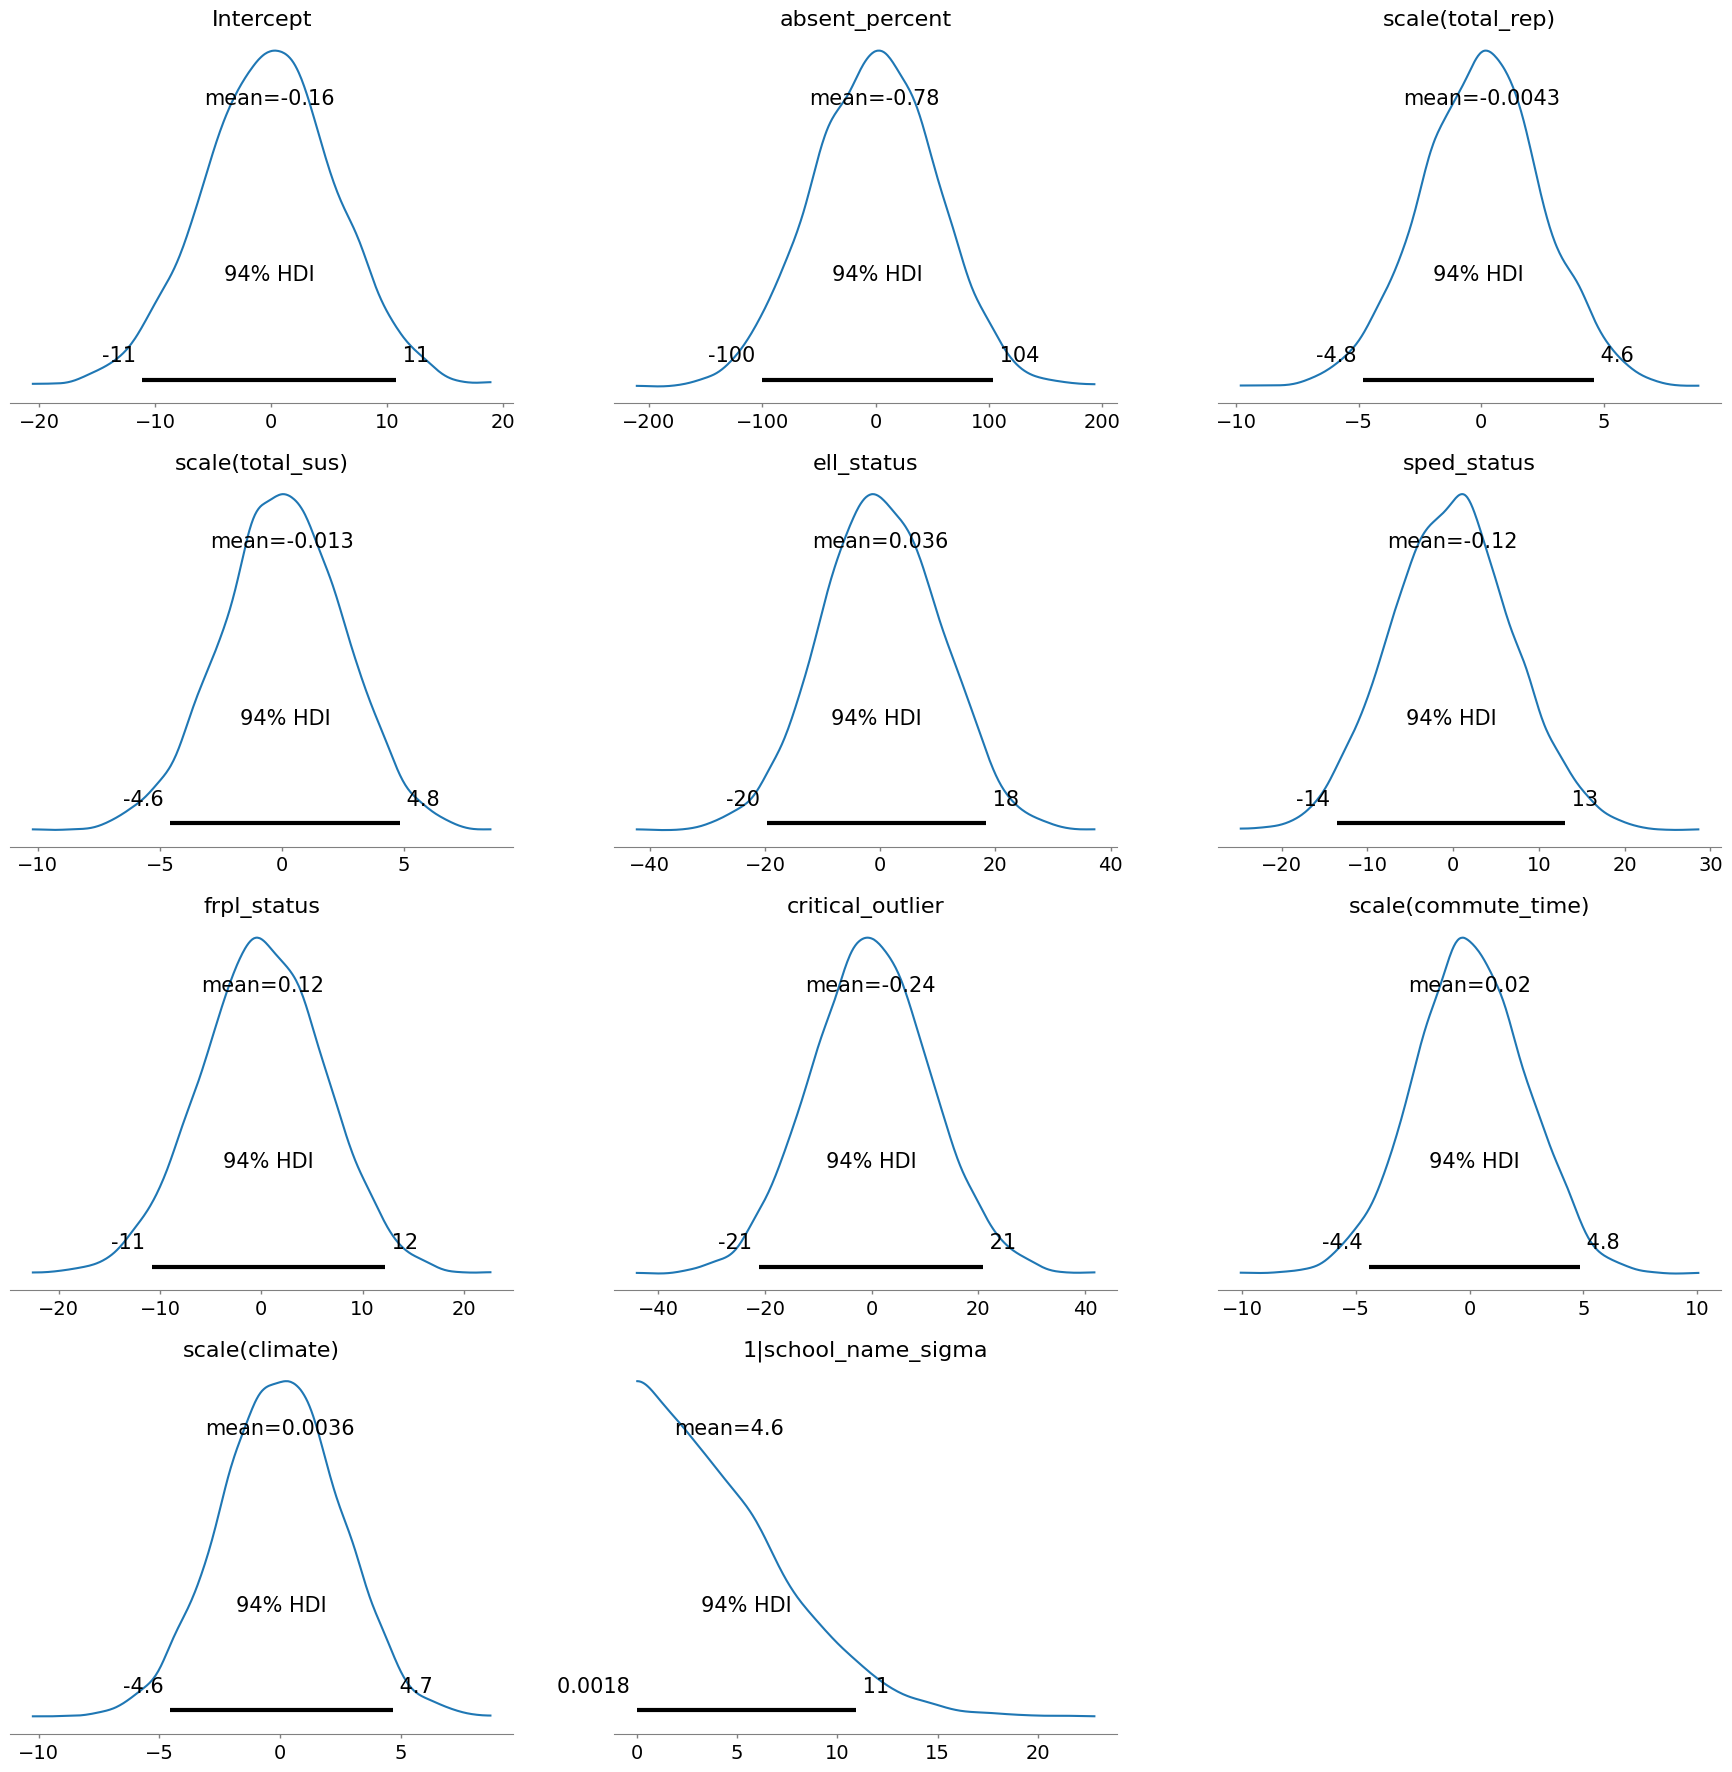

In [7]:
model.plot_priors()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'absent_percent'}>,
        <Axes: title={'center': 'absent_percent'}>],
       [<Axes: title={'center': 'scale(total_rep)'}>,
        <Axes: title={'center': 'scale(total_rep)'}>],
       [<Axes: title={'center': 'scale(total_sus)'}>,
        <Axes: title={'center': 'scale(total_sus)'}>],
       [<Axes: title={'center': 'ell_status'}>,
        <Axes: title={'center': 'ell_status'}>],
       [<Axes: title={'center': 'sped_status'}>,
        <Axes: title={'center': 'sped_status'}>],
       [<Axes: title={'center': 'frpl_status'}>,
        <Axes: title={'center': 'frpl_status'}>],
       [<Axes: title={'center': 'critical_outlier'}>,
        <Axes: title={'center': 'critical_outlier'}>],
       [<Axes: title={'center': 'scale(commute_time)'}>,
        <Axes: title={'center': 'scale(commute_time)'}>],
       [<Axes: title={'center': 'scale(climate)'}>,
        <Ax

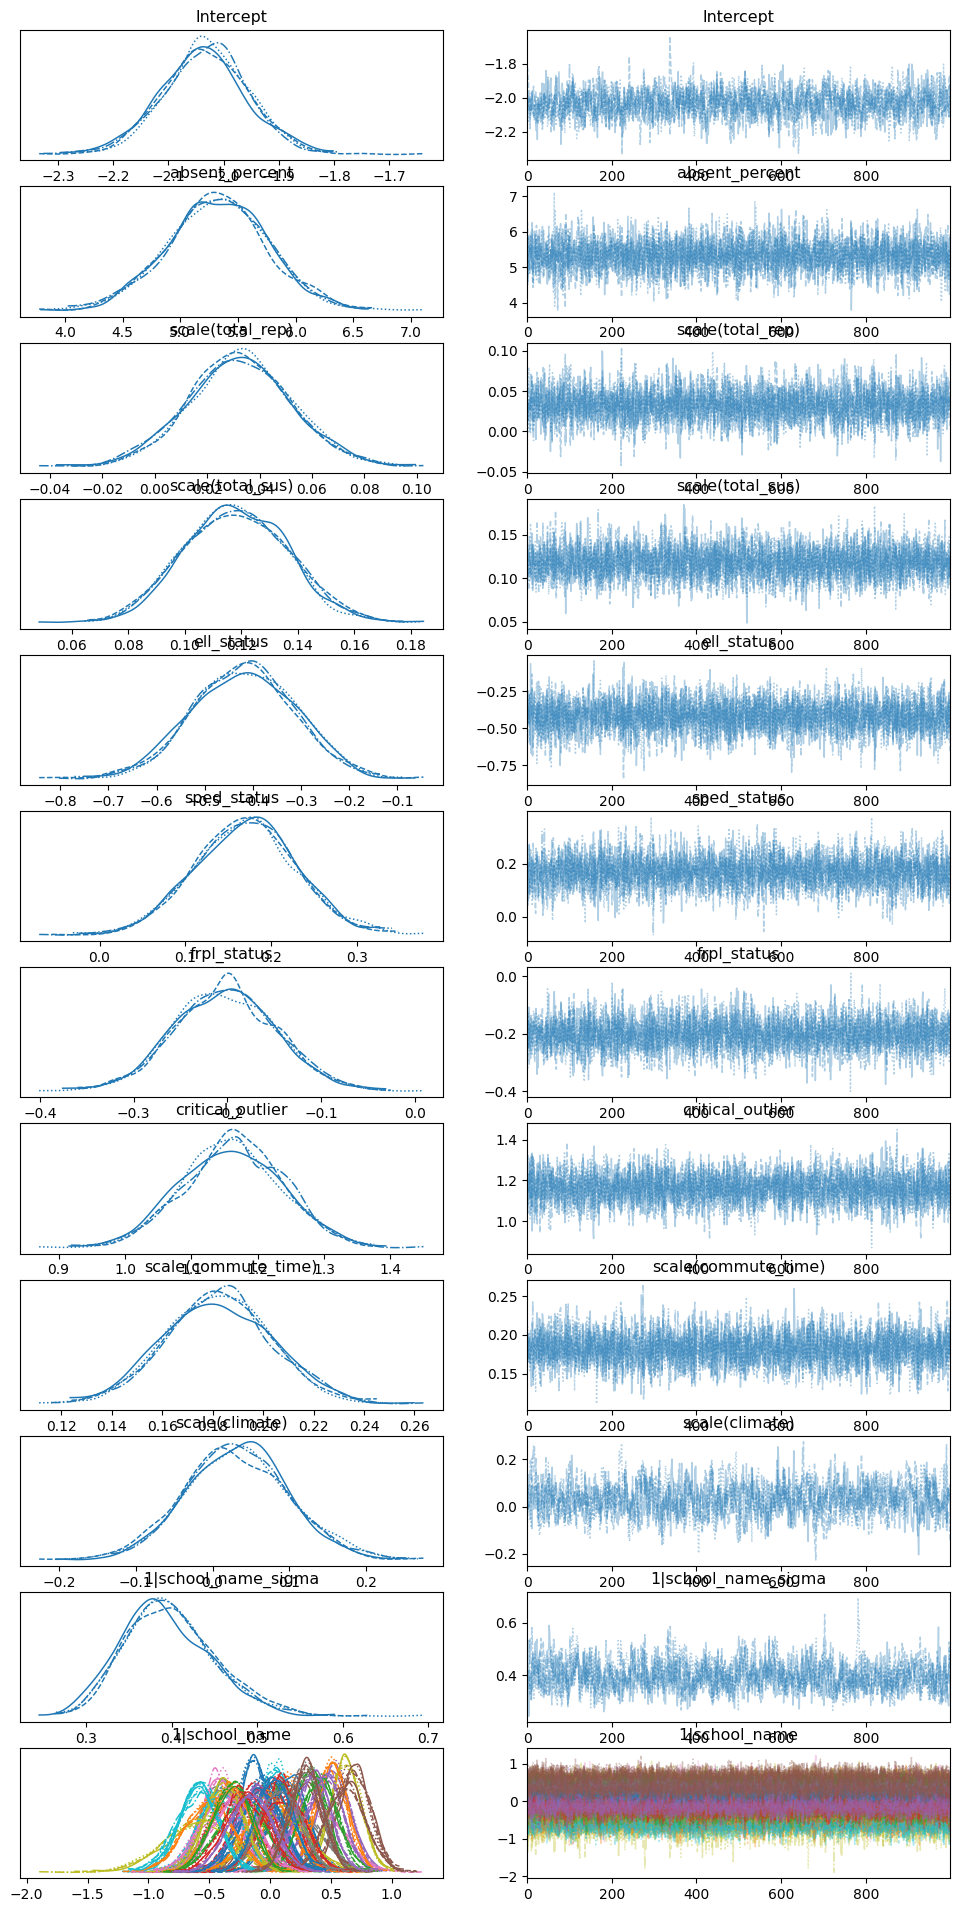

In [8]:
az.plot_trace(idata)

In [9]:
summary = az.summary(idata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.033,0.078,-2.175,-1.883,0.002,0.002,1084.0,1779.0,1.00
absent_percent,5.325,0.432,4.455,6.093,0.007,0.005,3760.0,2815.0,1.00
scale(total_rep),0.033,0.020,-0.005,0.070,0.000,0.000,3932.0,2793.0,1.00
scale(total_sus),0.118,0.018,0.085,0.152,0.000,0.000,3844.0,2859.0,1.00
ell_status,-0.419,0.106,-0.622,-0.227,0.002,0.001,4320.0,3037.0,1.00
sped_status,0.170,0.059,0.056,0.277,0.001,0.001,3929.0,3104.0,1.00
frpl_status,-0.202,0.055,-0.298,-0.092,0.001,0.001,3893.0,3212.0,1.00
critical_outlier,1.162,0.075,1.022,1.300,0.001,0.001,4052.0,2869.0,1.00
scale(commute_time),0.182,0.021,0.141,0.219,0.000,0.000,4082.0,2615.0,1.00
scale(climate),0.033,0.067,-0.094,0.157,0.002,0.002,737.0,1153.0,1.01


In [10]:
model.predict(idata, data = df_pred)
posterior_mean = idata.posterior["attrited_mean"].values.mean(0)
predictions = np.array(posterior_mean).mean(0)
print('Mean:',np.mean(predictions))
print('Max:',max(predictions))
print('Min:',min(predictions))

Mean: 0.1454951443929063
Max: 0.9394069869330494
Min: 0.044049785849832275


In [ ]:
# Bring back the school names for the kids that were 'Other'
schools = pd.DataFrame(dat_23)
schools = schools[['sa_scholar_id','school_name']]
schools['school_lookup'] = schools['school_name']
schools = schools.drop(['school_name'],axis=1)
df_pred = df_pred.merge(schools,how='left',on='sa_scholar_id')
df_pred['school_name'] = np.where(df_pred['school_name']=='Other',df_pred['school_lookup'],df_pred['school_name'])
df_pred = df_pred.drop(['school_lookup'],axis=1)

In [25]:
# Create variables grouping commute and attrition risk probabilities for dashboards
inter_yr_table = df_pred
inter_yr_table['commute'] = '0-10 min'
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==2,'10-20 min',inter_yr_table['commute'])
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==3,'20-30 min',inter_yr_table['commute'])
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==4,'30-40 min',inter_yr_table['commute'])
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==5,'40-50 min',inter_yr_table['commute'])
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==6,'50-60 min',inter_yr_table['commute'])
inter_yr_table['commute'] = np.where(inter_yr_table['commute_time']==7,'>60 min',inter_yr_table['commute'])
inter_yr_table['nearby_student_crimes'] = inter_yr_table['climate']
inter_yr_table = df_pred.drop(['precinct','climate'],axis=1)
inter_yr_table['predicted_prob'] = predictions
inter_yr_table['attrition_risk'] = '0-20%'
inter_yr_table['attrition_risk'] = np.where(inter_yr_table['predicted_prob']>0.2,'20-40%',inter_yr_table['attrition_risk'])
inter_yr_table['attrition_risk'] = np.where(inter_yr_table['predicted_prob']>0.4,'40-60%',inter_yr_table['attrition_risk'])
inter_yr_table['attrition_risk'] = np.where(inter_yr_table['predicted_prob']>0.6,'60-80%',inter_yr_table['attrition_risk'])
inter_yr_table['attrition_risk'] = np.where(inter_yr_table['predicted_prob']>0.8,'>80%',inter_yr_table['attrition_risk'])

In [90]:
inter_yr_table.to_csv('D:\\Users\\kmai\\Documents\\inter_year_attrition\\raw_data_science.raw_inter_year_predictions_bayesian_2023.csv', index=False)